In [1]:
from typing import Tuple, List
from collections import defaultdict

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
SUNSPOTS_PATH = "../../datasets/Sunspots.csv"

N_STEPS_IN = 100
N_STEPS_OUT = 50
TEST_FRAC = 0.1

In [3]:
def read_dataset(path: str) -> Tuple[pd.Series, pd.Series]:

    # Read data into a data frame
    df = pd.read_csv(path)

    # Preprocess data
    df.drop(df.columns[0], axis=1, inplace=True)    # Drop index collumn
    df['Date'] = pd.to_datetime(df['Date'])         # Always format the date
    df = df.sort_values(['Date'])                   # Sort by date

    # Extract timeseries from original dataframe
    sunspots_total = df['Monthly Mean Total Sunspot Number']
    sunspots_dates = df['Date']

    return sunspots_total, sunspots_dates


def train_test_split(dataset: pd.Series, test_fraction=0.1) -> Tuple[pd.Series, pd.Series]:

    # Assign the count variables
    all_obs = dataset.shape[0]
    test_obs = int(np.round(test_fraction * all_obs))
    train_obs = all_obs - test_obs

    # Split the dataset
    ds_train = dataset[:train_obs]
    ds_test = dataset[train_obs:]

    # Test split
    assert (dataset == pd.concat((ds_train, ds_test))).values.all(), "Train-Test split incorrect!"

    return ds_train, ds_test


def split_sequence_supervised(
        sequence: npt.NDArray,
        n_steps_in: int,
        n_steps_out: int,
        test_split: bool = False,
        shuffle: bool = False) -> Tuple[npt.NDArray, npt.NDArray]:
    
    # Get the start/cut index
    sequence_len = sequence.shape[0]
    n_steps_cycle = n_steps_in + n_steps_out
    n_cut = sequence_len % n_steps_cycle
    
    # Cut the sequence
    sequence = sequence[:-n_cut] if test_split else sequence[n_cut:]
    sequence_len = sequence.shape[0]
    
    # Create buckets
    x, y = list(), list()
    for i in range(sequence_len - n_steps_cycle + 1):

        start_x_idx = i
        start_y_idx = start_x_idx + n_steps_in

        x.append(sequence[start_x_idx:start_y_idx])
        y.append(sequence[start_y_idx:start_y_idx+n_steps_out])
    
    # Cast to NDArray
    x, y = np.array(x), np.array(y)

    # Shuffle
    if shuffle:
        np.random.shuffle(x)
        np.random.shuffle(y)

    return x, y

In [4]:
sunspots_total, sunspots_dates = read_dataset(SUNSPOTS_PATH)
sunspots_train, sunspots_test = train_test_split(sunspots_total, TEST_FRAC)

train_x, train_y = split_sequence_supervised(sunspots_train, N_STEPS_IN, N_STEPS_OUT, test_split=False, shuffle=False)
test_x,  test_y  = split_sequence_supervised(sunspots_test,  N_STEPS_IN, N_STEPS_OUT, test_split=True,  shuffle=False)

assert (sunspots_test[:N_STEPS_IN].values == test_x[0]).all(), "Train-test-split is incorrect!"
assert (sunspots_test[N_STEPS_IN:N_STEPS_IN+N_STEPS_OUT].values == test_y[0]).all(), "Train-test-split is incorrect!"

In [5]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(train_x, train_y)
# xgb_reg.save_model("saved/.json")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [6]:
def window_forecast(past_data_batch: npt.NDArray, pretrained_model: xgb.XGBRegressor) -> npt.NDArray:

    return np.squeeze(pretrained_model.predict(past_data_batch))

In [7]:
def get_forecast_series(forecast: npt.NDArray, train_ds_size: int, n_steps_in: int, n_steps_out: int) -> List[pd.Series]:

    series_list = list()
    for forecast_idx in range(forecast.shape[0]):

        series_start_idx = train_ds_size + n_steps_in + forecast_idx
        series_end_idx = train_ds_size + n_steps_in + forecast_idx + n_steps_out
        series_list.append(pd.Series(
            data=forecast[forecast_idx],
            index=range(series_start_idx, series_end_idx)
        ))
    
    return series_list

In [8]:
forecast = window_forecast(test_x, xgb_reg)
forecast_series = get_forecast_series(forecast, sunspots_train.size, N_STEPS_IN, N_STEPS_OUT)

assert forecast_series[0].index[0] == sunspots_train.index[-1] + N_STEPS_IN + 1, "Forecast series indexed incorrectly!"

In [9]:
def plot_forecast(dataset_series: pd.Series, forecast_series: List[pd.Series], idx: int, xlim: Tuple[int, int]):
    
    suffix = defaultdict(lambda: "th", {1: "st", 2: "nd", 3: "rd"})


    plt.scatter(dataset_series.index, dataset_series.values, color='tab:blue', label='Original', s=2)
    plt.scatter(forecast_series[idx].index, forecast_series[idx].values, color="tab:orange", label='Prediction', s=2)

    plt.legend()
    plt.xlabel("Month index")
    plt.ylabel("Monthly Mean Total Sunspot Number")
    plt.title(f"Forecast since {idx + 1}{suffix[idx + 1]} data patch")
    plt.xlim(xlim)
    plt.show()


def plot_forecasts(dataset_series: pd.Series, forecast_series: List[pd.Series], xlim: Tuple[int, int]):

    plt.scatter(dataset_series.index, dataset_series.values, color='tab:blue', label='Original', s=2)

    for series in forecast_series:
        plt.scatter(series.index, series.values, color="tab:orange", s=2, alpha=0.1)

    plt.scatter([-10], [0], color="tab:orange", label='Prediction', s=2, alpha=0.1)
    plt.legend()
    plt.xlabel("Month index")
    plt.ylabel("Monthly Mean Total Sunspot Number")
    plt.title("Sumaric forecast results")
    plt.xlim(xlim)
    plt.show()

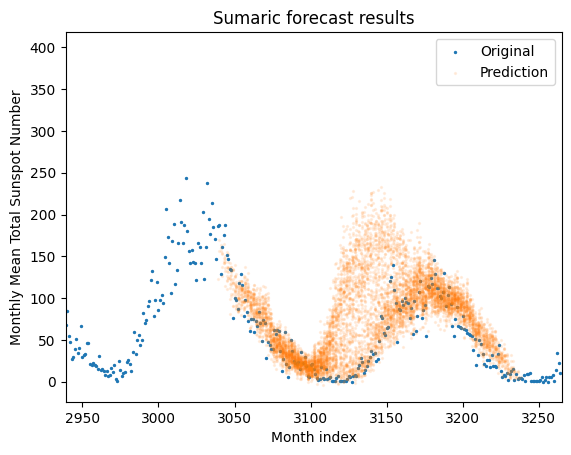

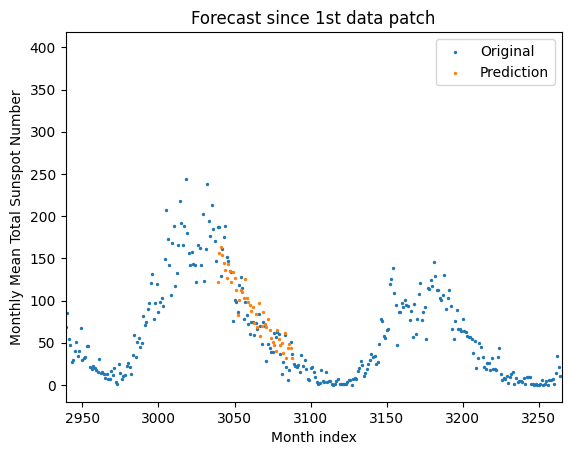

In [10]:
months_lim = (sunspots_train.size, sunspots_total.size)
plot_forecasts(sunspots_total, forecast_series, xlim=months_lim)
plot_forecast(sunspots_total, forecast_series, 0, xlim=months_lim)